# Minimum working example for Bayesian neural network + MNIST

## Code structure

There are two files of code:
1. `src/BayesNN.py` contains a class that implements the Bayesian neural network as well as methods to train it and to sample from its posterior. To use this class provide a list of Tensorflow layers (the final layer should be a DenseReparameterisation layer (https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseReparameterization).
2. `src/utils.py` contains miscellaneous functions to (e.g.) load data, compute RATE, make plots and to convert logits to predictions/test accuracy.

## Usage example

First load the packages and the data:

In [7]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp # Needs separate install on top of standard Tensorflow 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.stats import spearmanr, rankdata

# To import scripts from different directory
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, "/".join([parent_dir, "src"])) 

from utils import *
from BayesNN import BNN

x_train has shape (60000, 324)
y_train has shape (60000, 10)
x_test has shape (10000, 324)
y_test has shape (10000, 10)


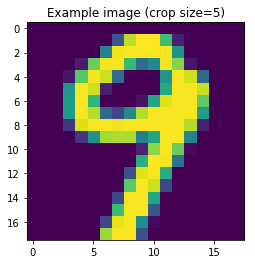

In [8]:
# Load data - one-hot encoded labels
# Need to crop at least 5 from the edges of the images to prevent numerical problems with RATE 
crop_size = 5
x_train, y_train, x_test, y_test = load_mnist(onehot_encode=True, flatten_x=True, crop_x=crop_size)
n_train = x_train.shape[0]
n_test = x_test.shape[0]
image_size = int(x_train.shape[1]**0.5)

# Input and output dimensionality
p = x_train.shape[1]
C = y_train.shape[1]

# Plot a random training example
fig, ax = plt.subplots()
ax.imshow(x_train[np.random.choice(n_train),:].reshape(image_size, image_size))
ax.set_title("Example image (crop size={})".format(crop_size))

Now define the network architecture. The BNN class constructor (defined in BayesNN) takes a list of Tensorflow layers. 

If the layers cannot be combined to make a model the build_model method (called in the constructor) will throw an error. This is usually because of mismatching shapes.

The architecture of this network is

    convolutional layer -> flatten -> dense layer -> dense Bayesian layer (-> softmax if making prediction)

In [9]:
layers = []
layers.append(tf.keras.layers.Reshape([image_size, image_size, 1], input_shape=(p,)))
layers.append(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
layers.append(tf.layers.Flatten())
layers.append(tf.keras.layers.Dense(512, activation='relu'))
layers.append(tfp.layers.DenseReparameterization(C))

Now create the BNN object:

In [10]:
bnn = BNN(layers, p, C)
print bnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 18, 18, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3211776   
_________________________________________________________________
dense_reparameterization (De (None, 10)                10250     
Total params: 3,222,858
Trainable params: 3,222,858
Non-trainable params: 0
_________________________________________________________________
None


Now train the network by calling the `train` method, which returns the training loss at each epoch and leaves the network trained. This is much faster on a GPU (if you have one). On the GPU on my laptop the training takes about 30 seconds.

In [11]:
n_epochs = 10
batch_size = 256
bnn.train(x_train, y_train, n_epochs, batch_size)

Training...
Epoch (10 in total):
0 1 2 3 4 5 6 7 8 9 


[105.20092263180986,
 65.67608756693001,
 58.350057879064835,
 53.50392941531972,
 50.080346164540344,
 47.131956801455246,
 44.87060740870288,
 43.201613108317055,
 41.031757729685204,
 39.63774289840307]

Evaluate the model by taking MC samples from the posterior for the test set. Plot the resulting test set accuracy for each set of samples.

Sampling (100 total)...
100  done


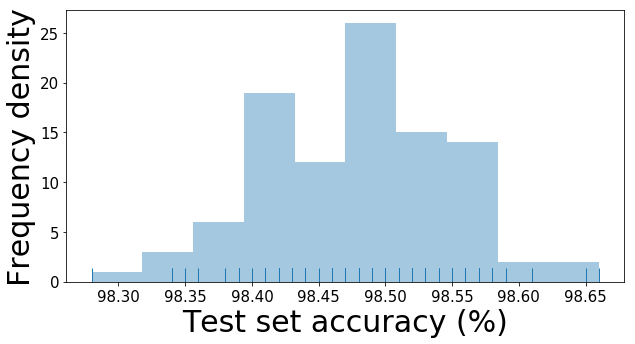

In [12]:
n_test_samples = 100
test_logits = bnn.sample_logits(x_test, n_test_samples)
accuracy_hist(test_logits, y_test)

## RATE

Now compute RATE. Start with the means and covariances of the final layer. Then get the network output at the penultimate layer, `H`, and use it to compute the means and covariances of the multivariate effect size analgoues.

In [13]:
M_W, V_W, b = bnn.var_params() # Means and covariances of the variational parameters (final layer weight matrix elements)
X = x_test # Using the whole test set
H = bnn.compute_H(X) # (Deterministic) values of penultimate network layer
M_B, V_B = compute_B(X, H, M_W, V_W, b, C) # Means and covariances of the effect size analogues
rate = [RATE(mu_c=M_B[c,:], Lambda_c=V_B[c,:,:]) for c in range(C)] # Per-class RATE values

0 100 200 300 0 100 200 300 0 100 200 300 0 100 200 300 0 100 200 300 0 100 200 300 0 100 200 300 0 100 200 300 0 100 200 300 0 100 200 300


Now we have these RATE values we have been trying to find good ways of visualising them for the paper. The plot below has too much for a paper but hopefully some of the plots will be included.

## Plots

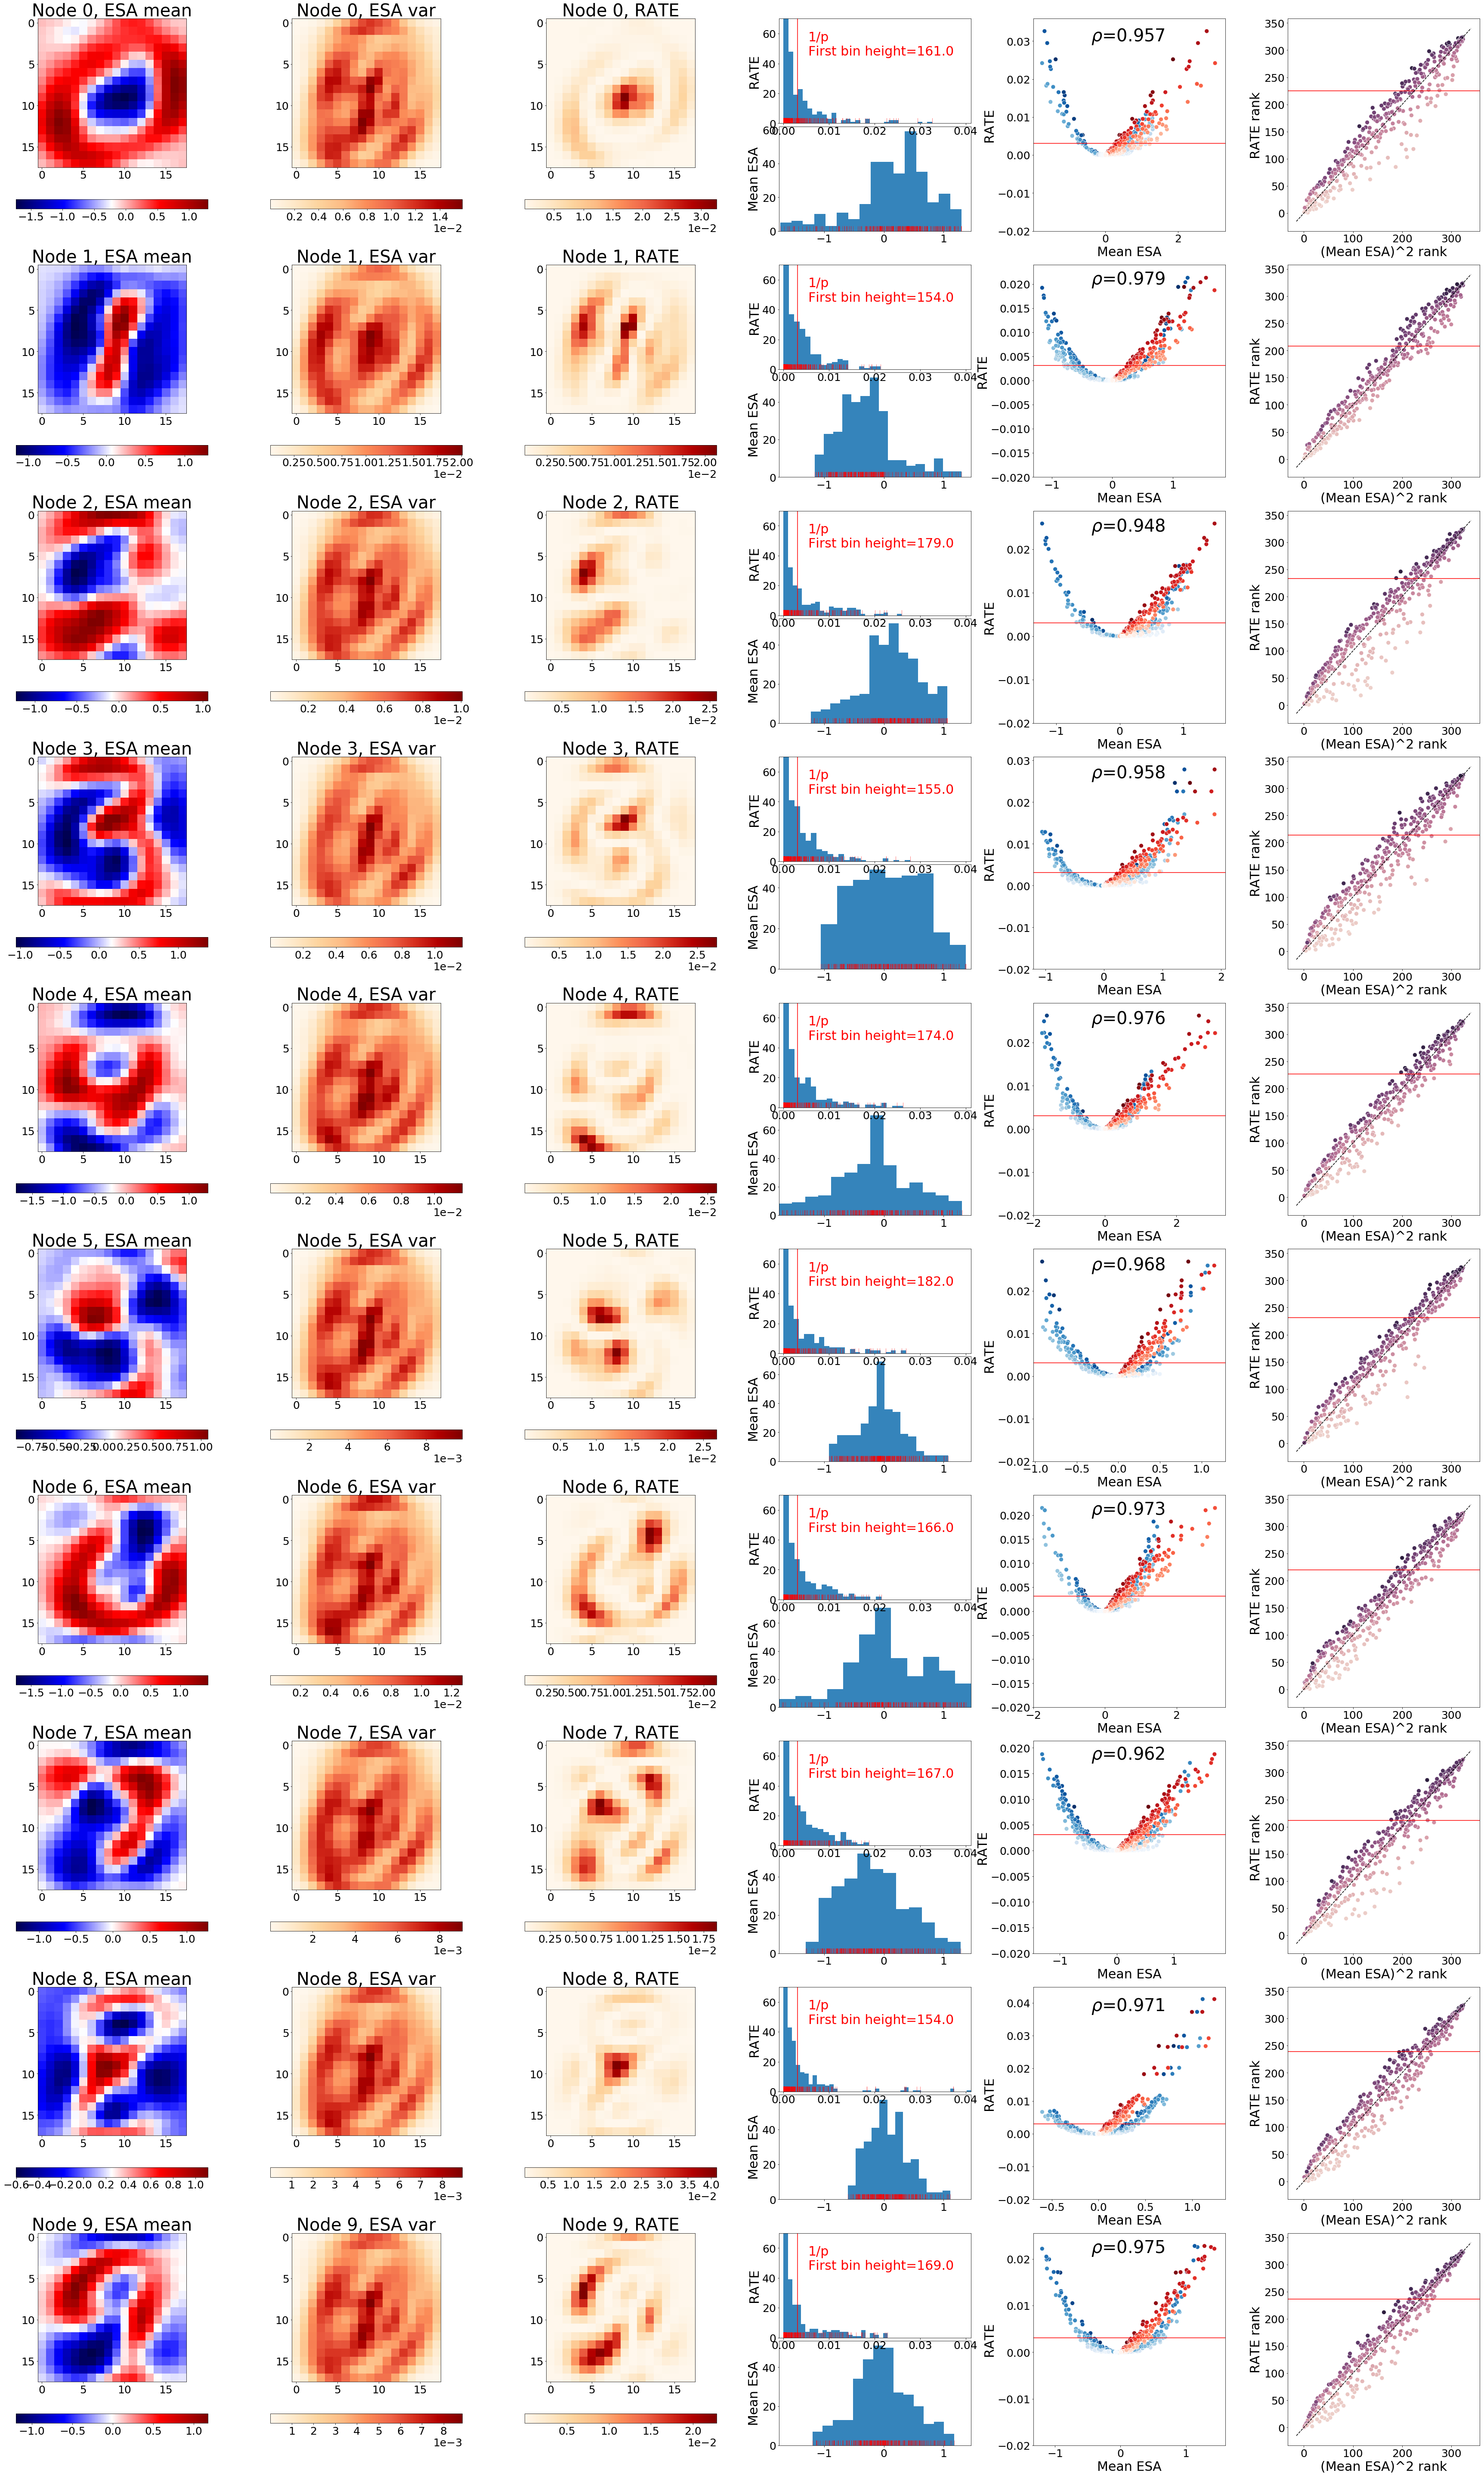

In [15]:
C_plot = 10 # Number of classes to plot (max 10)

# Plot aesthetics
plotsize = 8
tickfontsize = 25
plottitlesize = 40
axislabelfontsize = 30
markersize = 100

# For standardising axis limits across rows
rate_max = np.amax(np.array(rate))
rate_min = np.amin(np.array(rate))
M_B_max = np.amax(M_B)
M_B_min = np.amin(M_B)

fig, axes = plt.subplots(C_plot, 6, figsize=(6*plotsize, C_plot*plotsize))

for idx, ax in enumerate(axes):
    ims = []
    ax[0].set_title("Node {}, ESA mean".format(idx), fontsize=plottitlesize)
    ax[1].set_title("Node {}, ESA var".format(idx), fontsize=plottitlesize)
    ax[2].set_title("Node {}, RATE".format(idx), fontsize=plottitlesize)

    # Heatmaps
    ims.append(ax[0].imshow(M_B[idx,:].reshape(image_size, image_size),
                                        interpolation="none",
                                        cmap="seismic"))
    ims.append(ax[1].imshow(np.diag(V_B[idx,:]).reshape(image_size, image_size),
                                        interpolation="none",
                                        cmap="OrRd"))
    ims.append(ax[2].imshow(rate[idx].reshape(image_size, image_size),
                                         interpolation="none",
                                         cmap="OrRd"))

    # Histograms
    divider = make_axes_locatable(ax[3])
    axShallow = divider.append_axes("top", size="100%", pad=0.1)

    sns.distplot(M_B[idx,:], kde=False, rug=True, hist_kws={"alpha":0.9}, rug_kws={"color": "r", "alpha":0.5}, ax=ax[3])
    sns.distplot(rate[idx], kde=False, rug=True, hist_kws={"alpha":0.9}, rug_kws={"color": "r", "alpha":0.5}, ax=axShallow)
    ax[3].set_ylabel("Mean ESA", fontsize=axislabelfontsize)
    axShallow.set_ylabel("RATE", fontsize=axislabelfontsize)
    axShallow.axvline(1.0/rate[idx].shape[0], color="red")
        
    axShallow.set_xlim([rate_min-0.001, rate_max])
    ax[3].set_xlim([M_B_min, M_B_max])

    axShallow.set_ylim([0, 70])
    ylim = axShallow.get_ylim()
    xlim = axShallow.get_xlim()
    axShallow.text(1.0/rate[idx].shape[0] + (xlim[1]-xlim[0])/18.0, 0.65*ylim[1],
                       "1/p\nFirst bin height={}".format(axShallow.patches[0].get_height()),
                       color="red", fontsize=axislabelfontsize)

    # Scatterplots
    hue = np.diag(V_B[idx,:])
    hue = hue/np.amax(hue)
    sns.scatterplot(M_B[idx,:], rate[idx],
                    palette="Blues", hue=hue, s=markersize,
                    label="Mean ESA vs RATE", ax=ax[4])
    sns.scatterplot(M_B[idx,:]**2.0, rate[idx],
                    palette="Reds", hue=hue, s=markersize,
                    label="(Mean ESA)^2 vs RATE", ax=ax[4])
    ax[4].set_xlabel("Mean ESA", fontsize=axislabelfontsize)
    ax[4].set_ylabel("RATE", fontsize=axislabelfontsize)
    #ax[4].legend(loc=8, ncol=1, prop=dict(size=axislabelfontsize-5))
    ax[4].axhline(1.0/rate[idx].shape[0], color="red")
    ax[4].get_legend().remove()

    ylim = ax[4].get_ylim()
    xlim = ax[4].get_xlim()
    ax[4].text(0.3*(xlim[1]-xlim[0]) + xlim[0], 0.85*(ylim[1]-ylim[0]) + ylim[0], 
                   r'$\rho$={0:.3f}'.format(spearmanr(rate[idx],  M_B[idx,:]**2.0)[0]),
                  fontsize=axislabelfontsize+10)
    ax[4].set_ylim([-0.02, ylim[1]])
    
    # Rankings
    ranked_rate = rankdata(rate[idx])
    ranked_esa_sq = rankdata(M_B[idx,:]**2.0)
    sns.scatterplot(ranked_esa_sq, ranked_rate, hue=hue, s=markersize, ax=ax[5])
    ax[5].set_xlabel("(Mean ESA)^2 rank", fontsize=axislabelfontsize)
    ax[5].set_ylabel("RATE rank", fontsize=axislabelfontsize)
    ax[5].get_legend().remove()
    ax[5].axhline(np.where(np.sort(rate[idx])<1.0/p)[0][-1], color="red")
    ax[5].plot(ax[5].get_xlim(), ax[5].get_ylim(), ls="--", color="black")
    
    # Tick font sizes on all plots
    ax[0].tick_params("both", labelsize=tickfontsize)
    ax[1].tick_params("both", labelsize=tickfontsize)
    ax[2].tick_params("both", labelsize=tickfontsize)
    ax[3].tick_params("both", labelsize=tickfontsize)
    ax[4].tick_params("both", labelsize=tickfontsize)
    ax[5].tick_params("both", labelsize=tickfontsize)
    axShallow.tick_params("both", labelsize=tickfontsize)

    # Colourbars
    cbs = [fig.colorbar(ims[i], ax=ax[i], orientation="horizontal") for i in range(3)]
    for cb in cbs:
        cb.formatter.set_scientific(True)
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()
        cb.ax.xaxis.offsetText.set_fontsize(tickfontsize)
        cb.ax.tick_params("both", labelsize=tickfontsize)

plt.tight_layout()

For the plots above:
* Each row of plots is for a single node of the final layer, which corresponds to a single class - this is why you can see the outline of each digit in the first three columns of plots. Each row contains plots showing (from left to right):

    1. the mean of the ESA (effect size analogue) posterior for that node (pixel-by-pixel)
    
    2. the variance of the ESA posterior for that node (pixel-by-pixel)
    3. the corresponding RATE values for that node (pixel-by-pixel)
    4. Histograms of the RATE (upper) and ESA (lower) values. The red line in the upper plot that covers the whole heightof the plot is is $1/p$, where $p$ is the number of pixels. The other red lines are the rug. The y axis limits of the RATE plot have been reduced to better see the height of the bins at larger RATE values so the original height of that bin is state.
    5. Scatter plots of the ESA and RATE values (blue) and the square of the ESA and RATE (orange). Also shown is the Spearman correlation (rho) between the square of the ESA and RATE (since ESA mean can be negative). The intensity of each point indicates the ESA posterior variance, with higher intensity indicating higher variance.
    6. The pixel rankings according to their RATE values vs the rankings according to the square of the ESA posterior mean. The color of the points indicates the variance of the ESA marginal posterior for each pixel, with a darker colour meaning a larger variance. It looks like the difference in ranking between RATE and mean ESA can be explained by the variance. The red line on this plot shows 1/p. The intensity of each point indicates the ESA posterior variance, with higher intensity indicating higher variance. If the rankings were identical all the points would lie on the diagonal, black line.
    
    
* RATE combines the information of the ESA posterior mean and covaraince when ranking the pixels. This can most clearly be seen from the final column of plots, as the difference in pixel ranking using RATE and (mean ESA)^2 can be explained by the ESA posterior variance of the pixel (larger variances lie in the upper-right part of the plot, which is where the RATE rank is higher than the mean ESA rank, and vice versa).